In [240]:
import numpy as np
from scipy.optimize import fsolve
from IPython.display import display, Markdown
from sympy import *
from sympy import latex as ltx

# Derivatives
x = symbols(r'x', real=True)
N1, N2 = symbols(r'N_1 N_2', real=True)
d1, d2, d3 = symbols(r'd_1 d_2 d_3', real=True)
N1 = x * d1 / ( 10 - d1) - 0.5 * d2**2
N2 = d2 - d1

display ( Markdown( f"$\\frac{{\\partial N_1}}{{\\partial d_1}} = {ltx(diff(N1,d1))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_1}}{{\\partial d_2}} = {ltx(diff(N1,d2))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_2}}{{\\partial d_1}} = {ltx(diff(N2,d1))}$" ) )
display ( Markdown( f"$\\frac{{\\partial N_2}}{{\\partial d_2}} = {ltx(diff(N2,d2))}$" ) )


$\frac{\partial N_1}{\partial d_1} = \frac{d_{1} x}{\left(10 - d_{1}\right)^{2}} + \frac{x}{10 - d_{1}}$

$\frac{\partial N_1}{\partial d_2} = - 1.0 d_{2}$

$\frac{\partial N_2}{\partial d_1} = -1$

$\frac{\partial N_2}{\partial d_2} = 1$

Running LOAD STEP 0 (F1=0.250)
Newton loop --- 0
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
delta_d: [0.16666667 0.16666667] Re:[0.25 0.  ] x:15 Fi1:0.0 Fi2:0.0
foo([0]:0.041666666666666664
delta_d: [0.16666667 0.16666667] Re:[0.25 0.  ] x:15 Fi1:0.0 Fi2:0.0
foo([0]:0.041666666666666664
delta_d: [0.16666667 0.16666667] Re:[0.25 0.  ] x:15 Fi1:0.0 Fi2:0.0
foo([0.]:0.041666666666666664
delta_d: [0.16666667 0.16666667] Re:[0.25 0.  ] x:15 Fi1:0.0 Fi2:0.0
foo([0.]:0.041666666666666664
delta_d: [0.16666667 0.16666667] Re:[0.25 0.  ] x:15 Fi1:3.7252902963112718e-09 Fi2:0.0
foo([1.49011612e-08]:0.04166666604578495
delta_d: [0.16666667 0.16666667] Re:[0.0096516 0.       ] x:15 Fi1:0.24034840010688777 Fi2:0.0
foo([1.]:0.0016085999821853721
delta_d: [0.16666667 0.16666667] Re:[0.00040002 0.        ] x:15 Fi1:0.2495999821053215 Fi2:0.0
foo([1.04015671]:6.66696491130834e-05
delta_d: [0.16666667 0.16666667] Re:[6.91060418e-07 0.00000000e+00] x:15 Fi1:0.24999930893958203 Fi2:0.0
foo

''

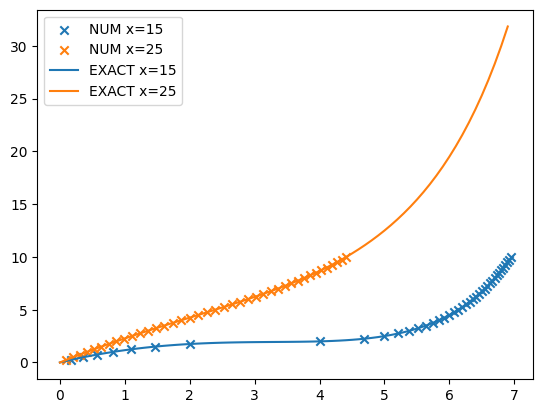

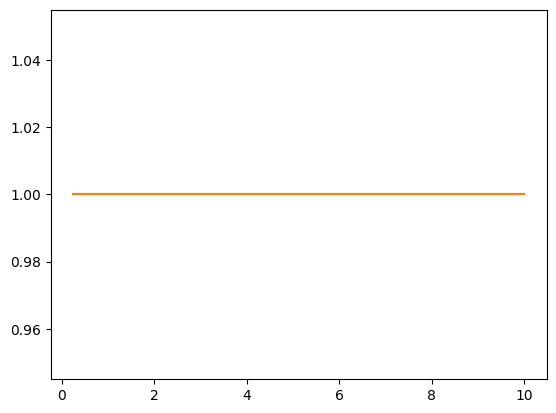

In [262]:

def run_sim( x, line_search=False, modif_nr=False,  line_search_maxit=1000, line_search_fast_s=False, BFGS=False ) :
    global G0,d, delta_d, K_inv, v_, alpha_, w_, delta_R_, R_, R
    # Load steps
    F1 = 0
    delta_F1 = 0.25
    
    ls_s=1
    RET_F, RET_D, RET_I = [], [], []
    
    # Load steps
    d = np.array( [ 0. , 0. ] )
    N1 = x * d[0] / (10 - d[0]) - 0.5 * d[1]**2
    N2 = d[1] - d[0]

    for n in range(40) :
        F1 += delta_F1
        F2 = 0
        print(f"Running LOAD STEP {n} (F1={F1:.3f})")
        CONVERGED = False

        # Newton loop
        for i in range(15) :
            print(f"Newton loop --- {i}")
            prev_N = np.array( [ N1, N2 ] ) 
                
            N1 = x * d[0] / (10 - d[0]) - 0.5 * d[1]**2
            N2 = d[1] - d[0]
            
            # Check convergence
            R1 = F1 - N1
            R2 = F2 - N2
            R_ = np.array( [ R1, R2 ] )
            
            R = sqrt( R1**2 + R2**2 )
            if not i : 
                if R > 1e-5 : R0=R
                else : R0 = 1e-5
    
            if R > 1e50 : break  # Crash!
            print(f"{i:3d}: R={R:.5e} R/R0={R/R0:.5f}")
            
            if R/R0 < 1e-4 :
                CONVERGED = True
                break
    
            # Update the tangent in the first interacion only if modified NR is chosen
            if not modif_nr or not i :
                dN1_dd1 = d[0] * x / (10 - d[0])**2 + x / (10 - d[0])
                dN1_dd2 = - d[1]
                dN2_dd1 = -1
                dN2_dd2 = 1
    
            K = [ [ dN1_dd1, dN1_dd2],
                  [ dN2_dd1, dN2_dd2 ] ]
            K = np.array(K)

            if BFGS and i:
                delta_R_ = prev_N - np.array([N1, N2])
                v_      =  delta_d/(delta_d.dot( delta_R_ ) )
                alpha_  =  np.sqrt( - ls_s * delta_R_.dot(delta_d)/R_.dot(delta_d))
                w_      =  - delta_R_ + alpha_ * R_

                R_bfgs = ( np.eye(2) + np.outer(w_, v_) ).dot(R_)
                dd = np.linalg.inv(K).dot(R_bfgs)
                delta_d = ( np.eye(2) + np.outer(v_,w_) ).dot(dd)
                
            else :
                K_inv = np.linalg.inv(K)
                delta_d = K_inv.dot( R_ )

            
            
            if line_search :
                print("        Line search enabled.")
                G0 = 0

                def foo(s):
                    global G0
                    d_ = d + s * delta_d
                    Fi1 = x * d_[0] / (10 - d_[0]) - 0.5 * d_[1]**2
                    Fi2 = d_[1] - d_[0]
                    f = delta_d.dot( np.array([F1,F2]) - np.array([Fi1,Fi2]) )
                    
                    print(f"delta_d: {delta_d} Re:{np.array([F1,F2]) - np.array([Fi1,Fi2])} x:{x} Fi1:{Fi1} Fi2:{Fi2}")
                    
                    if line_search_fast_s :
                        if abs(f) < abs(G0/2) : 
                            # interrupt.
                            print("        FAST S!")
                            return 0 
                    
                    print(f"foo({s}:{f}")
                    return f
                G0 = foo([0])            
                
                ls_s = fsolve(foo,0, maxfev=line_search_maxit)
                print(f"        Find s ... G0:{G0} s={ls_s} dd:{delta_d} ")
                # print(f"ls_s: [{ls_s}]")
                test_f = abs(foo(ls_s))
                if (test_f >= abs(G0/2)) :
                    print(f"[FAILED] Cannot find acceptable s in line search - test_f[{test_f:.4e} > abs(G0/2)[{abs(G0/2):.4e}]]")
                    return RET_D, RET_F, RET_I
            print(f"DELTA D {delta_d}")
            print(f"ls_s {ls_s}")
            print(f"D {d}")
            d += delta_d * ls_s

        if not CONVERGED : 
            print(f"[FAILED] The solver did not converge after {i} iterations. Giving up.")    
            return RET_D, RET_F, RET_I
                        
        RET_D.append(d.copy())
        RET_I.append(i)
        RET_F.append(F1)
        
    return RET_D, RET_F, RET_I
    

full_run( line_search=True, modif_nr=False, line_search_maxit=10000, line_search_fast_s=False )
""

In [244]:
v=np.array([5,6])
w=np.array([3,4        ])
np.outer(w,v)

array([[15, 18],
       [20, 24]])

#### 1) Exact $N_1(d_1,d_2=d_1)$ vs. $d_1$ for x=15 and x=25

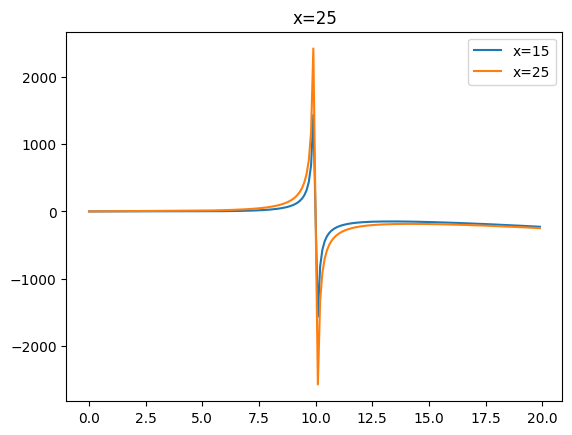

In [245]:
import matplotlib.pyplot as plt
import numpy as np
def cN1(x,d) :
    N1 = x * d[0] / (10. - d[0]) - 0.5 * d[1]**2
    return N1

d0_ = np.arange(0,20,.1)
d0 = np.array( [ i for i in d0_ if i != 10] )

d0 = [ d0, d0 ]
N15exact = cN1(15,d0)
plt.plot( d0[0], N15exact, label="x=15" )
plt.title("x=15")
N25exact = cN1(25,d0)
plt.plot( d0[0], N25exact, label="x=25" )
plt.title("x=25")
plt.legend()

In [246]:
def full_run(line_search, modif_nr=False,  line_search_maxit=1000, line_search_fast_s=False, BFGS=False) :
    x=15
    D15,F15,I15 = run_sim( x=x, line_search=line_search, modif_nr=modif_nr, line_search_maxit=line_search_maxit, line_search_fast_s=line_search_fast_s, BFGS=BFGS )
    d15 = np.array( [ [i,i] for i,j in D15 ] ).T
    N15 = cN1(x,d15)
    
    x=25
    D25,F25,I25 = run_sim( x=x, line_search=line_search, modif_nr=modif_nr, line_search_maxit=line_search_maxit, line_search_fast_s=line_search_fast_s, BFGS=BFGS )
    d25 = np.array( [ [i,i] for i,j in D25 ] ).T
    N25 = cN1(x,d25)
    
    # PLOT NUMERICAL
    plt.scatter( d15[0], N15, label="NUM x=15", marker='x' )
    plt.scatter( d25[0], N25, label="NUM x=25", marker='x' )
    # PLOT EXACT
    d0_ = np.arange(0,7,.1)
    d0 = np.array( [ i for i in d0_ if i != 10] )
    d0 = [ d0, d0 ]
    N15exact = cN1(15,d0)
    plt.plot( d0[0], N15exact, label="EXACT x=15" )
    N25exact = cN1(25,d0)
    plt.plot( d0[0], N25exact, label="EXACT x=25" )
    plt.legend()
    
    plt.figure()
    plt.plot(F15,I15,label="Iterations x=15")
    plt.plot(F25,I25,label="Iterations x=25")

Running LOAD STEP 0 (F1=0.250)
  0: R=2.50000e-1 R/R0=1.00000
DELTA D [0.16666667 0.16666667]
ls_s 1
D [0. 0.]
  1: R=9.65160e-3 R/R0=0.03861
DELTA D [0.00697062 0.00697062]
ls_s 1
D [0.16666667 0.16666667]
  2: R=1.66240e-5 R/R0=0.00007
Running LOAD STEP 1 (F1=0.500)
  0: R=2.50017e-1 R/R0=1.00000
DELTA D [0.18119211 0.18119211]
ls_s 1
D [0.17363729 0.17363729]
  1: R=1.11275e-2 R/R0=0.04451
DELTA D [0.00884844 0.00884844]
ls_s 1
D [0.3548294 0.3548294]
  2: R=2.60468e-5 R/R0=0.00010
DELTA D [2.08094796e-05 2.08094796e-05]
ls_s 1
D [0.36367784 0.36367784]
  3: R=1.43927e-10 R/R0=0.00000
Running LOAD STEP 2 (F1=0.750)
  0: R=2.50000e-1 R/R0=1.00000
DELTA D [0.19973383 0.19973383]
ls_s 1
D [0.36369865 0.36369865]
  1: R=1.31178e-2 R/R0=0.05247
DELTA D [0.01170145 0.01170145]
ls_s 1
D [0.56343248 0.56343248]
  2: R=4.39901e-5 R/R0=0.00018
DELTA D [3.95054095e-05 3.95054095e-05]
ls_s 1
D [0.57513394 0.57513394]
  3: R=5.00711e-10 R/R0=0.00000
Running LOAD STEP 3 (F1=1.000)
  0: R=2.50000e

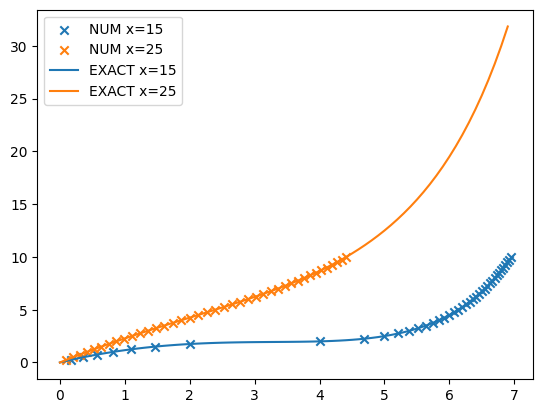

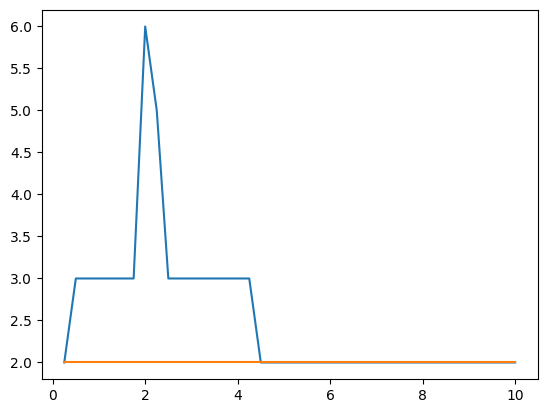

In [247]:
full_run( line_search=False, modif_nr=False, line_search_maxit=10000, line_search_fast_s=False )

Running LOAD STEP 0 (F1=0.250)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
        Find s ... s=[1.041896]
DELTA D [0.16666667 0.16666667]
ls_s [1.041896]
D [0. 0.]
  1: R=2.77556e-17 R/R0=0.00000
Running LOAD STEP 1 (F1=0.500)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
        Find s ... s=[1.04894644]
DELTA D [0.18118115 0.18118115]
ls_s [1.04894644]
D [0.17364933 0.17364933]
  1: R=7.85046e-17 R/R0=0.00000
Running LOAD STEP 2 (F1=0.750)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
        Find s ... s=[1.05878302]
DELTA D [0.19973383 0.19973383]
ls_s [1.05878302]
D [0.36369865 0.36369865]
  1: R=3.33067e-16 R/R0=0.00000
Running LOAD STEP 3 (F1=1.000)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
        Find s ... s=[1.07344893]
DELTA D [0.22451819 0.22451819]
ls_s [1.07344893]
D [0.57517344 0.57517344]
  1: R=0.00000e+4 R/R0=0.00000
Running LOAD STEP 4 (F1=1.250)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled

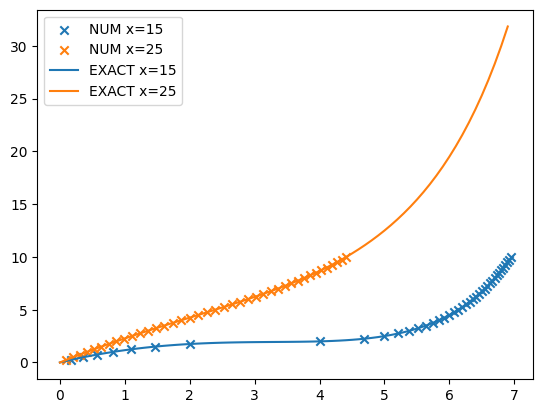

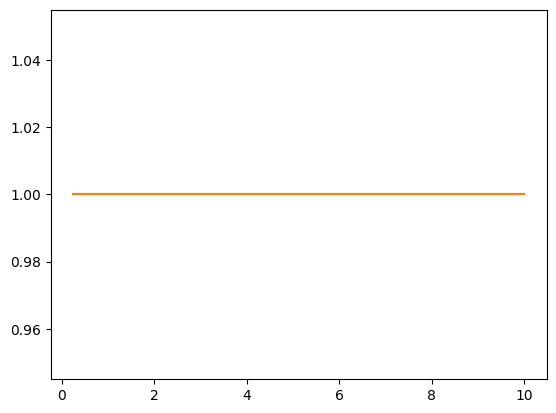

In [253]:
full_run( line_search=True, modif_nr=False, line_search_maxit=10000, line_search_fast_s=False )

Running LOAD STEP 0 (F1=0.250)
  0: R=2.50000e-1 R/R0=1.00000
DELTA D [0.16666667 0.16666667]
ls_s 1
D [0. 0.]
  1: R=9.65160e-3 R/R0=0.03861
DELTA D [0.0064344 0.0064344]
ls_s 1
D [0.16666667 0.16666667]
  2: R=7.56620e-4 R/R0=0.00303
DELTA D [0.00050441 0.00050441]
ls_s 1
D [0.17310107 0.17310107]
  3: R=6.05109e-5 R/R0=0.00024
DELTA D [4.03406146e-05 4.03406146e-05]
ls_s 1
D [0.17360548 0.17360548]
  4: R=4.84690e-6 R/R0=0.00002
Running LOAD STEP 1 (F1=0.500)
  0: R=2.50005e-1 R/R0=1.00000
DELTA D [0.18118434 0.18118434]
ls_s 1
D [0.17364582 0.17364582]
  1: R=1.11265e-2 R/R0=0.04451
DELTA D [0.00806366 0.00806366]
ls_s 1
D [0.35483017 0.35483017]
  2: R=1.00759e-3 R/R0=0.00403
DELTA D [0.00073022 0.00073022]
ls_s 1
D [0.36289382 0.36289382]
  3: R=9.33803e-5 R/R0=0.00037
DELTA D [6.76748752e-05 6.76748752e-05]
ls_s 1
D [0.36362405 0.36362405]
  4: R=8.67213e-6 R/R0=0.00003
Running LOAD STEP 2 (F1=0.750)
  0: R=2.50009e-1 R/R0=1.00000
DELTA D [0.19974003 0.19974003]
ls_s 1
D [0.3636

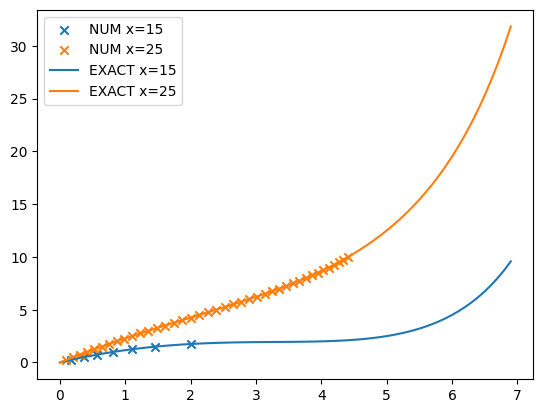

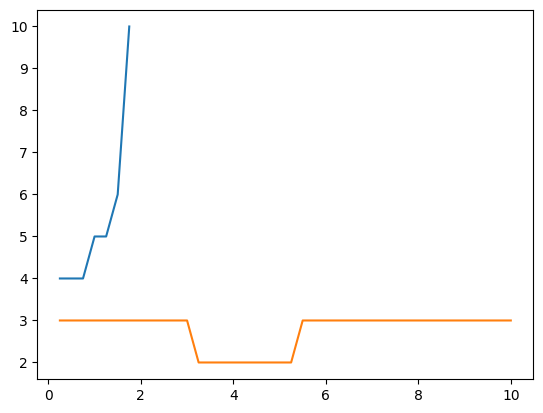

In [249]:
full_run( line_search=False, modif_nr=True, line_search_maxit=10000, line_search_fast_s=False )

In [250]:
full_run( line_search=True, modif_nr=True, line_search_maxit=5, line_search_fast_s=True )

Running LOAD STEP 0 (F1=0.250)
  0: R=2.50000e-1 R/R0=1.00000
        Line search enabled.
        FAST S!


NameError: name 's' is not defined

In [251]:
full_run( line_search=False, modif_nr=True, line_search_maxit=10000, line_search_fast_s=False, BFGS=True )

Running LOAD STEP 0 (F1=0.250)
  0: R=2.50000e-1 R/R0=1.00000
DELTA D [0.16666667 0.16666667]
ls_s 1
D [0. 0.]
  1: R=9.65160e-3 R/R0=0.03861
DELTA D [0.00025838 0.00025838]
ls_s 1
D [0.16666667 0.16666667]
  2: R=9.29386e-3 R/R0=0.03718
DELTA D [0.1609662 0.1609662]
ls_s 1
D [0.16692505 0.16692505]
  3: R=2.04754e-1 R/R0=0.81902
DELTA D [nan nan]
ls_s 1
D [0.32789125 0.32789125]


C:\Users\BFQ9\AppData\Local\Temp\ipykernel_20552\4038500059.py:59: RuntimeWarning: invalid value encountered in sqrt
  alpha_  =  np.sqrt( - ls_s * delta_R_.dot(delta_d)/R_.dot(delta_d))


TypeError: Invalid NaN comparison